# Fragmentation, dissolution and mineralisation rates

Fragmentation rate $k_\text{frag}$ and dissolution rate $k_\text{diss}$ constants control the rate at which polymer mass is lost from particle size classes, either to smaller size classes (fragmentation) or dissolved organics (dissolution). The mineralisation rate constant $k_\text{min}$ controls the rate at which dissolved organics are completely broken down into their mineral components, such as CO<sub>2</sub>. These rate constants have units of inverse time (s<sup>-1</sup> in SI units) and thus, for a given period of time $t + \Delta t$, a mass $m = \Delta t k_{t}$ of polymer fragments, dissolves or mineralises from a given pool. For fragmentation, the [](./advanced-usage/fragment-size-distribution.md) controls how this mass is split amongst daughter size classes. [](./dissolution-mineralisation.ipynb) describes in more detail the relationship between dissolution and mineralisation.

Fragmentation and dissolution rate constants can vary in time and across particle surface areas, and thus they are 2D arrays with dimensions `(n_timesteps, n_size_classes)`. The mineralisation rate constant can vary in time, and is therefore a 1D array with dimensions `(n_timesteps)`. These dependencies are controlled by the parameters provided in [model input data](../input-data), specifically to the `k_frag`, `k_diss` and `k_min` variables. If scalars are provided to these, the rates are constant in time and surface area, and if a dict of regression parameters is provided, the rate constants vary in time and surface area (`k_frag` and `k_diss`), or just in time (`k_min`), according to these parameters, as detailed here.

The rate constant distributions are built using either a compound relationship:

$$
k(t,s) = k_f T(t) S(s) + k_0
$$

or an additive relationship:

$$
k(t,s) = k_f (T(t) + S(s)) + k_0
$$

You can specify which is used by specifying the boolean `is_compound` in the `k_frag` or `k_diss` input data dict. Here, `t` is the time dimension, `s` is the particle surface area dimension, `k_f` is the rate constant scaling factor, `k_0` is the rate constant baseline adjustment factor and `k` could be `k_frag` or `k_diss`. `T(t)` is the expression used to create the time-dependence distribution, and `S(s)` the surface area distribution. In the case of mineralisation, only `T(t)` is used. Both of these take the same form, which allows for power law, exponential, logarithmic and logistic regressions:

$$
X(x) = A_x \hat{x}^{\alpha_x} \cdot B_x e^{-\beta_x \hat{x}}
       \cdot C_x \ln (\gamma_x \hat{x}) \cdot
       \frac{D_x}{1 + e^{-\delta_{x,1}(\hat{x} - \delta_{x,2})}}
$$

or if the user specifies a list for parameter $A_x$, a polynomial instead of power law can be used:

$$
X(x) = \sum_{n=1}^N A_{x,n} \hat{x}^n \cdot B_x e^{-\beta_x \hat{x}} \cdot
       C_x \ln (\gamma_x \hat{x}) \cdot \frac{D_x}{1 + e^{-\delta_{x,1}(\hat{x}
       - \delta_{x,2})}}
$$

Here, `X(x)` is either `T(t)` or `S(s)`. The parameters `A_t`, `A_s`, `alpha_t` etc are the parameters provided to the `k_frag`, `k_diss` and `k_min` dicts in the input data. The dimension value $\hat{x}$ is normalised such that the median value is equal to 1: $\hat{x} = x/\tilde{x}$, where $\tilde{x}$ is the median of $x$. This ensures regressions are not skewed by `t` and `s` values that are many orders of magnitude apart.

```{admonition} Smallest size class
:class: note
The model presumes that *no* fragmentation happens from the smallest size class, and so `k_frag` is always set to 0 for this size class. This is in constast to dissolution, which can happen from this size class.
```


## Regression parameters

```{list-table}
:header-rows: 1
:name: k-regression-params
:widths: auto

* - Parameter
  - Type, default
  - Description
* - `k_f`
  - Float, required
  - Rate constant scaling factor
* - `k_0`
  - Float, default=0
  - Rate constant baseline adjustment factor
* - `A_t`, `A_s`
  - Float or list, default=1
  - Power law coefficient. If a scalar is provided, this is used as the coefficient for a power law expression with `alpha_x` as the exponent. If a list is provided, these are used as coefficients in a polynomial expression, where the order of the polynomial is given by the length of the list. For example, if a length-2 list `A_t=[2, 3]` is given, then the resulting polynomial will be `3*t**2 + 2*t` (note the list is in *ascending* order of polynomials).
* - `alpha_t`, `alpha_s`
  - Float, default=0
  - If `A_x` is a scalar, `alpha_x` is the exponent for this power law expression. For example, if `A_t=2` and `alpha_t=0.5`, the resulting power law will be `2*t**0.5`.
* - `B_t`, `B_s`
  - Float, default=1
  - Exponential coefficient
* - `beta_t`, `beta_s`
  - Float, default=0
  - Exponential scaling factor
* - `C_t`, `C_s`
  - Float or None, default=None
  - If a scalar is given, this is the coefficient for the natural logarithmic term. If `None` is given, the logarithmic term is set to 1 (i.e. it is ignored).
* - `gamma_t`, `gamma_s`
  - Float, default=1
  - Logarithmic scaling factor
* - `D_t`, `D_s`
  - Float or None, default=None
  - If a scalar is given, this is the coefficient for the logistic term. If `None` is given, the logistic term is set to 1.
* - `delta1_t`, `delta1_s`
  - Float, default=1
  - Logistic growth rate (steepness of the logistic term)
* - `delta2_t`, `delta2_s`
  - Float or None, default=None
  - Midpoint of the logistic curve, which denotes the `t` or `s` value where the logistic curve is at its midpoint. If `None` is given, the midpoint is assumed to be the at the midpoint of the `t` or `s` range. For example, if the model timesteps go from 1 to 100, then the default for `delta2_t` is 50.
* - `is_compound`
  - Bool, default=True
  - Whether the `t` and `s` regression terms should be combined by multiplying them together (compound) or adding them. Choice depends on whether you think the time- and size-dependence of rate constants affect each other or act independently.
```

```{admonition} Negative k values
:class: warning
Make sure to specify regression parameters that do not end up in negative `k` values. The model checks for these before running and will throw a `FMNPDistributionValueError` exception if any are found.
```

## Examples

The make this more understandable, here are some examples are how you might use these parameters in real life. The first thing to note is that, if you want a k distribution to follow one particular regression, such as logistic, then you only need to specify parameters for that regression and the defaults take care of making sure the other regressions are constant. Taking a logistic regression as an example for `k_frag`:

Text(0, 0.5, 'k_frag')

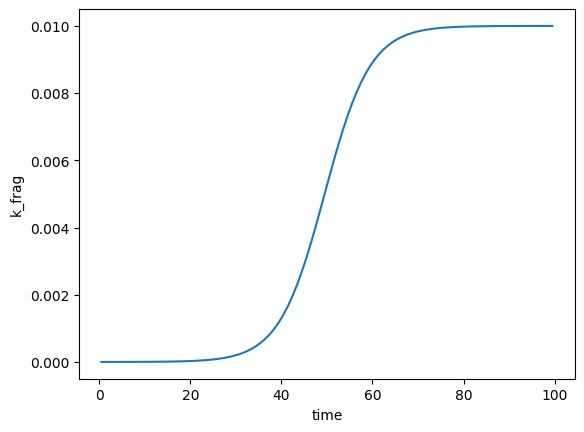

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fragmentmnp import FragmentMNP
from fragmentmnp.examples import minimal_config, minimal_data

# By specifying D_t=1, we are telling the model that we want a
# logistic regression over time for k_frag. delta1_t controls
# the steepness of the logistic
minimal_data['k_frag'] = {
    'k_f': 0.01,
    'D_t': 1,
    'delta1_t': 10
}

# Init the model with these data, which generates the k distributions
fmnp = FragmentMNP(minimal_config, minimal_data)

# Plot the k_frag distribution to check that it is logistic. We
# didn't specify any surface area dependence params and so we
# can pick any size class except the smallest (which always 
# has k_frag=0)
plt.plot(fmnp.t_grid, fmnp.k_frag[1, :])
plt.xlabel('time')
plt.ylabel('k_frag');

In the above, we effectively specified that `k_frag` should follow the regresion $k_\text{frag} = 0.01 / (1 + e^{-(\hat{t} - 1)})$. Let's now introduce a linear surface area dependence. Because the particle size classes are log-spaced, we plot with a log yscale in order to see the fragmentation rates for the smaller size classes:

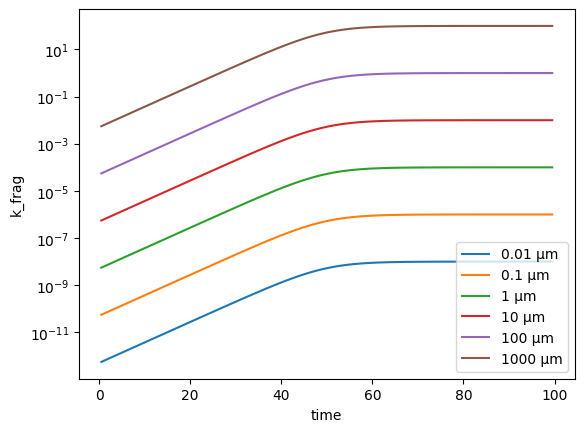

In [4]:
# Specify a logistic regression over t and linear over s
minimal_data['k_frag'] = {
    'k_f': 0.01,
    'D_t': 1,
    'delta1_t': 10,
    'A_s': [0.01]
}

# Init the model
fmnp = FragmentMNP(minimal_config, minimal_data)

# Plot k_frag for all size classes except the smallest
plt.plot(fmnp.t_grid, fmnp.k_frag[1:, :].T)
plt.legend([f'{c * 1e6:<1g} µm' for c in fmnp.psd[1:]])
plt.xlabel('time')
plt.ylabel('k_frag')
plt.yscale('log');


We can double check that the surface area dependence is linear by plotting the surface area against `k_frag` for one timestep:

Text(0, 0.5, 'k_frag')

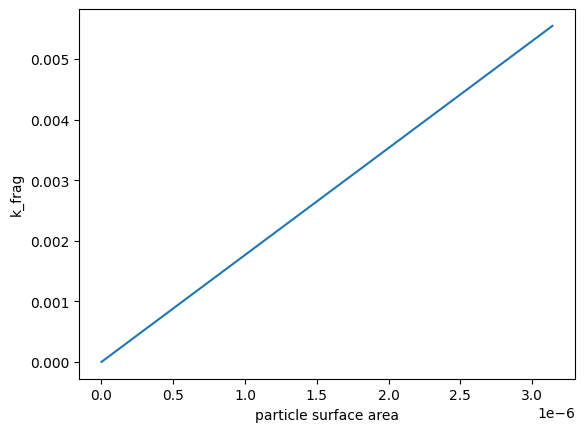

In [5]:
plt.plot(fmnp.surface_areas[1:], fmnp.k_frag[1:, 0])
plt.xlabel('particle surface area')
plt.ylabel('k_frag');

Combining regressions can make for some weird and wonderful distribution shapes:  

Text(0, 0.5, 'k_frag')

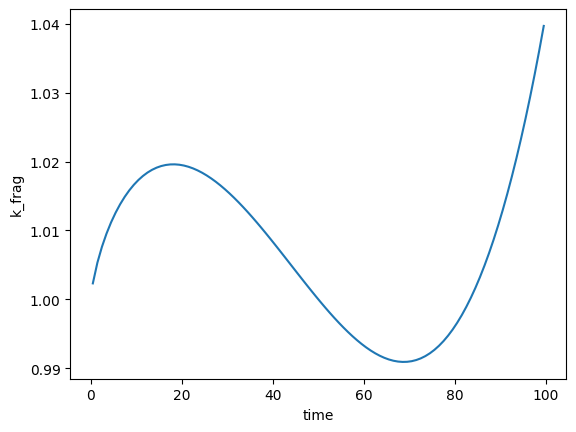

In [ ]:
# Third-order polynomial combined with a logarithmic regression - why not!?
minimal_data['k_frag'] = {
    'k_f': 0.01,
    'k_0': 1,
    'A_t': [-5, -2, 3],
    'C_t': 1
}
# Create and plot
fmnp = FragmentMNP(minimal_config, minimal_data)
plt.plot(fmnp.t_grid, fmnp.k_frag[1, :])
plt.xlabel('time')
plt.ylabel('k_frag');

## Setting your own rate constant regressions

If the time and size dependencies that can be achieved using the regression parammeters above are not flexible enough for your scenario, you can of course set your own $k_\text{frag}$, $k_\text{diss}$ or $k_\text{min}$ arrays by modifying the `k_frag`, `k_diss` or `k_min` attributes directly after initialising the model:

In [24]:
# Set a random k_frag array (really?!)
fmnp.k_frag = np.random.rand(fmnp.n_size_classes, fmnp.n_timesteps)